**Title: Star Classification**

**Introduction**

There are billions of stars in our sky and every star is unique. There are brown, white, and red dwarfs, main sequence stars like the sun and also hyper and super giants. We can use various properties of the star to determine which category it belongs to. In this data analysis, we will look at a star dataset which includes features of 240 stars. These features include the surface temperature in Kelvins, the luminosity (energy emitted per second) in solar luminosity, radius in solar radius, visual magnitude, star type, star colour, and stellar class. Luminosity is the amount of energy generated per second by the star and is given in stellar units. This means that a luminosity of 100 means 100 times more luminous than the sun. The radius is also how big it is in stellar units, and a radius of 10 means 10 times bigger than the sun.
Researchers have used the Hertzsprung-Russell Diagram to plot star features in order to determine a star’s type. To further our understanding of this diagram, we want to utilize k-nn classification to imitate aspects of the diagram and predict a new star’s type. The question we will address is whether we can effectively, consistently, and accurately classify a new star’s type based on its luminosity, radius, and temperature from current observations of various stars.


In [32]:
#Load all libraries and set plot dimensions
set.seed(2021)
options(repr.plot.height = 8, repr.plot.width = 10)
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

#Load data frame and changed the column names to more convenient
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR0bAqJh1jznOVyOZbHPL3kLbFjX6YzCWwMh3vMZEeBZq95tdDfcN9vqDP6XUf2j167vXr4oxnDvhb4/pub?gid=1536482276&single=true&output=csv"
star <- read_csv(url)

star_data <- star %>% 
    mutate("Star color" = as_factor("Star color"),
           "Spectral Class" = as_factor("Spectral Class")) %>%
    rename(star_type = "Star type",
           star_color = "Star color",
           spectral_class = "Spectral Class",
           temperature = "Temperature (K)",
           radius = "Radius(R/Ro)",
           luminosity = "Luminosity(L/Lo)",
           absolute_magnitude = "Absolute magnitude(Mv)") %>%
    tibble()


#Renamed numerical values of star type to their actual name 
star_data$star_type[star_data$star_type == 0] <- "Brown Dwarf"
star_data$star_type[star_data$star_type == 1] <- "Red Dwarf"
star_data$star_type[star_data$star_type == 2] <- "White Dwarf"
star_data$star_type[star_data$star_type == 3] <- "Main Sequence"
star_data$star_type[star_data$star_type == 4] <- "Super Giant"
star_data$star_type[star_data$star_type == 5] <- "Hyper Giant"

#Changed star_type to a factor and also applied log10 function to all predictors
star_data <- star_data %>%
    mutate(star_type = as_factor(star_type),
          luminosity = log10(luminosity),
          radius = log10(radius),
          temperature = log10(temperature))

Parsed with column specification:
cols(
  `Temperature (K)` = col_double(),
  `Luminosity(L/Lo)` = col_double(),
  `Radius(R/Ro)` = col_double(),
  `Absolute magnitude(Mv)` = col_double(),
  `Star type` = col_double(),
  `Star color` = col_character(),
  `Spectral Class` = col_character()
)



In [33]:
#Split the data into a training set and testing set 
star_split <- initial_split(star_data, prop = 0.6, strata = star_type)
star_train <- training(star_split)
star_test <- testing(star_split)

In [34]:
#Plot indicating the number of observations in each star type and averages of all predictor variables
star_distribution <- star_train %>%
    select(temperature, radius, luminosity, star_type) %>%
    group_by(star_type) %>%
    summarize(stars_in_class = n(), luminosity_avg = mean(luminosity), radius_avg = mean(radius), temperature_avg = mean(temperature))
star_distribution

`summarise()` ungrouping output (override with `.groups` argument)



star_type,stars_in_class,luminosity_avg,radius_avg,temperature_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Brown Dwarf,24,-3.301053,-0.9716997,3.487667
Red Dwarf,24,-2.638399,-0.4508259,3.521290
White Dwarf,24,-3.255689,-1.9819181,4.103465
Main Sequence,24,2.620062,0.5182337,4.140168
Super Giant,24,5.403859,1.6075249,4.034411
Hyper Giant,24,5.402195,3.1589321,3.818536


**Table 1**

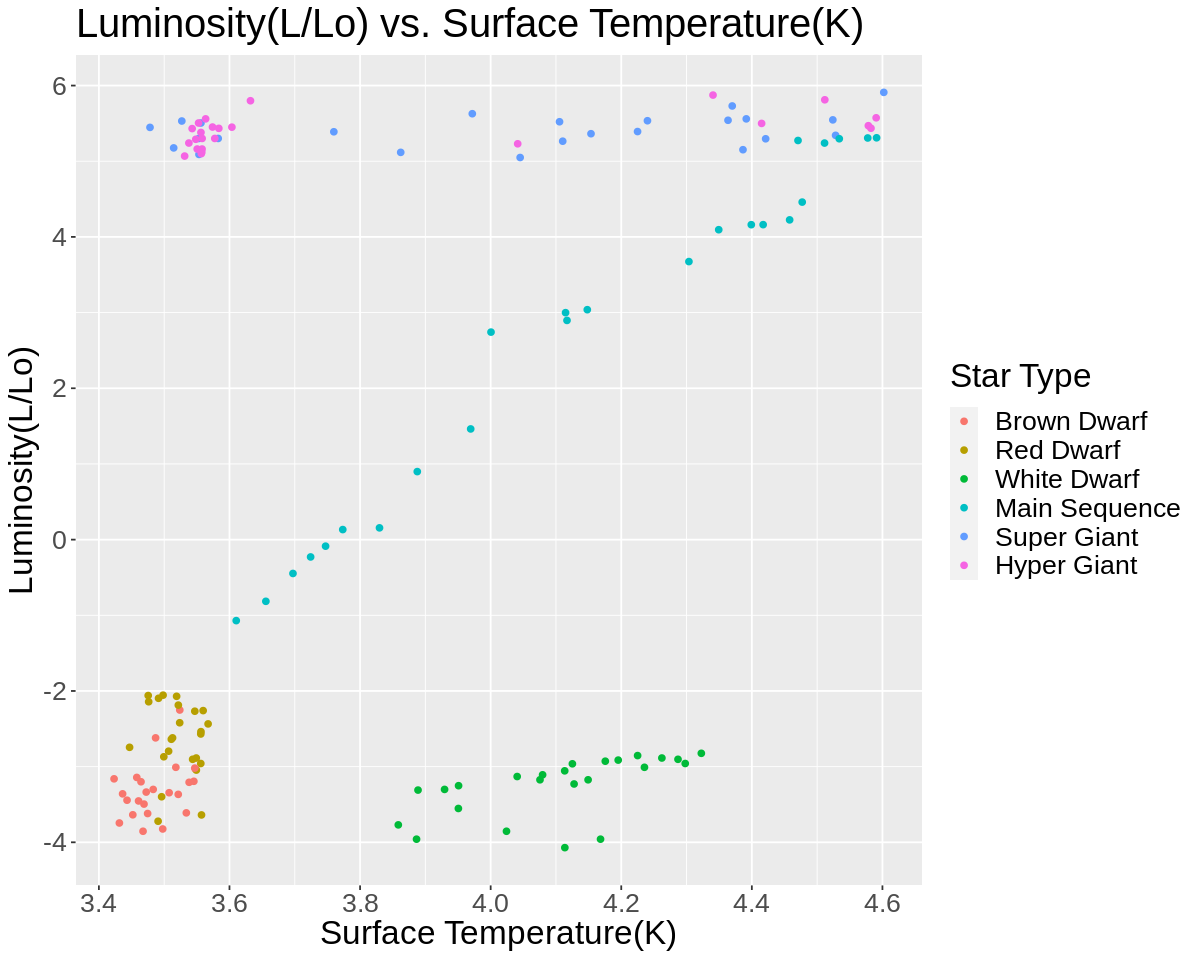

In [35]:
#Visualization of Luminosity(L/Lo) vs. Temperature(K)
star_plot <- star_train %>%
    ggplot(aes(x = temperature, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(L/Lo) vs. Surface Temperature(K)") +
    labs(x = "Surface Temperature(K)", y = "Luminosity(L/Lo)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot 

**Figure 1**

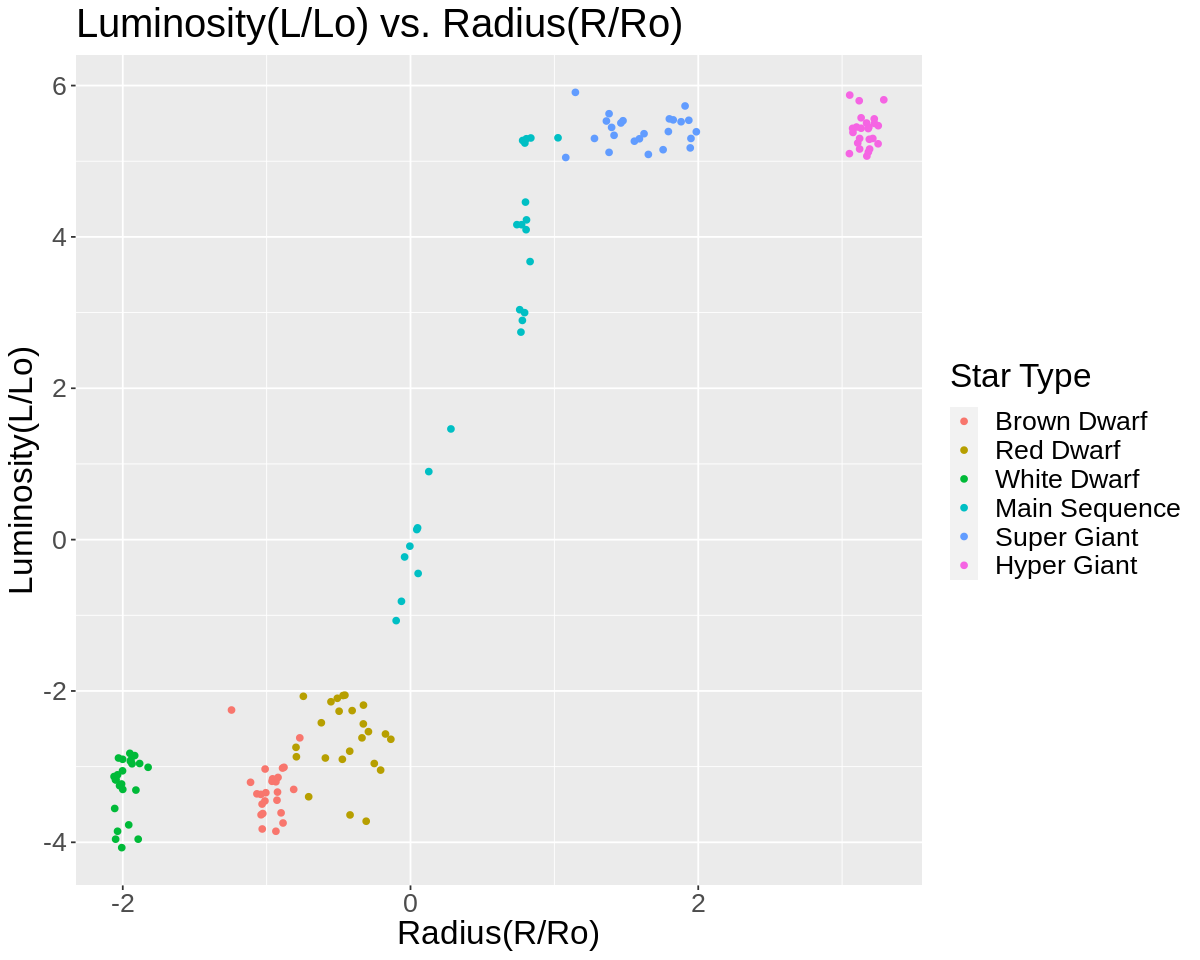

In [36]:
#Visualization of Luminosity(L/Lo) vs. Radius(R/Ro)
star_plot_2 <- star_train %>%
    ggplot(aes(x = radius, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(L/Lo) vs. Radius(R/Ro)") +
    labs(x = "Radius(R/Ro)", y = "Luminosity(L/Lo)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_2

**Figure 2**

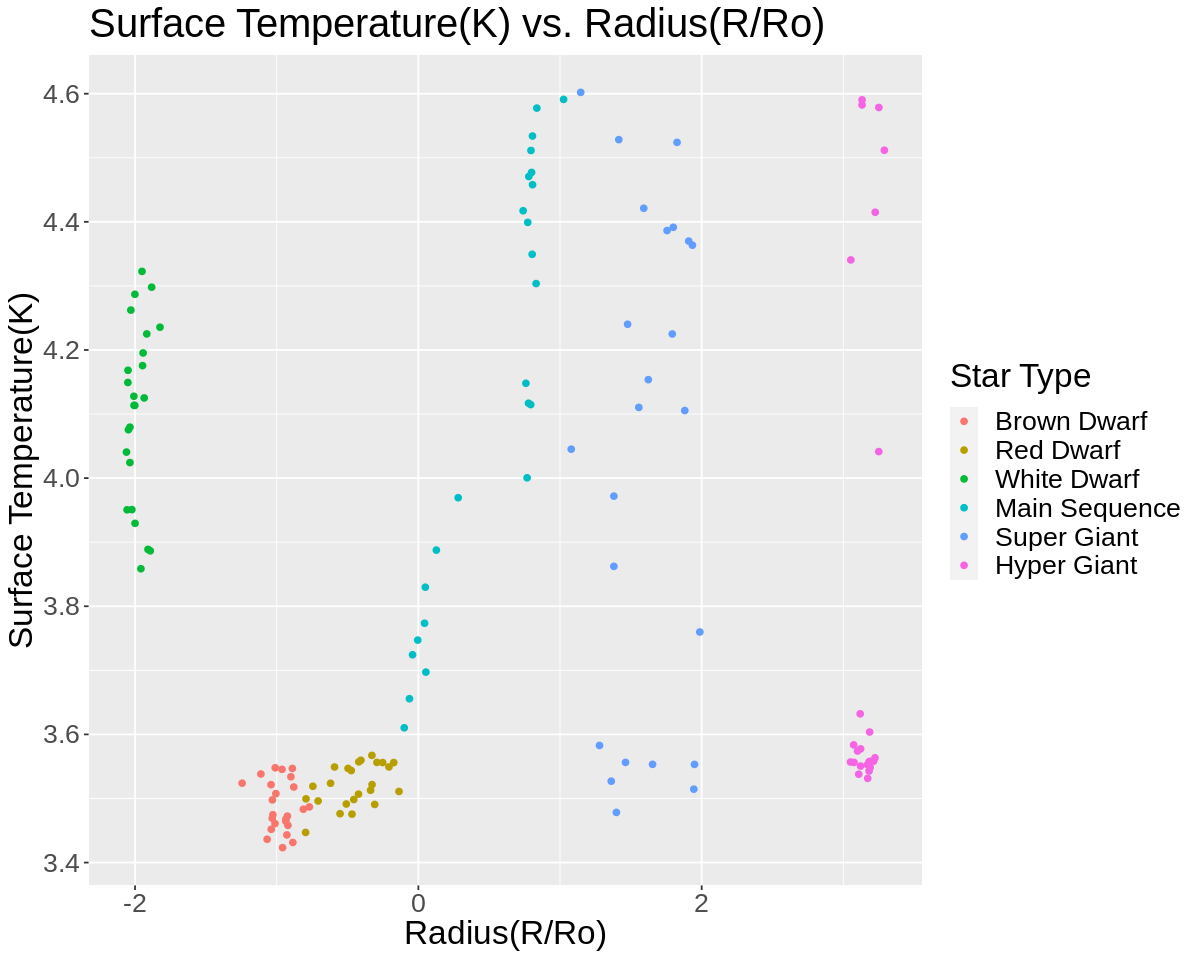

In [37]:
#Visualization of Temperature(K) vs. Radius(R/Ro)
star_plot_3 <- star_train %>%
    ggplot(aes(x = radius, y = temperature, color = star_type)) + 
    geom_point() +
    ggtitle("Surface Temperature(K) vs. Radius(R/Ro)") +
    labs(x = "Radius(R/Ro)", y = "Surface Temperature(K)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_3

**Figure 3**

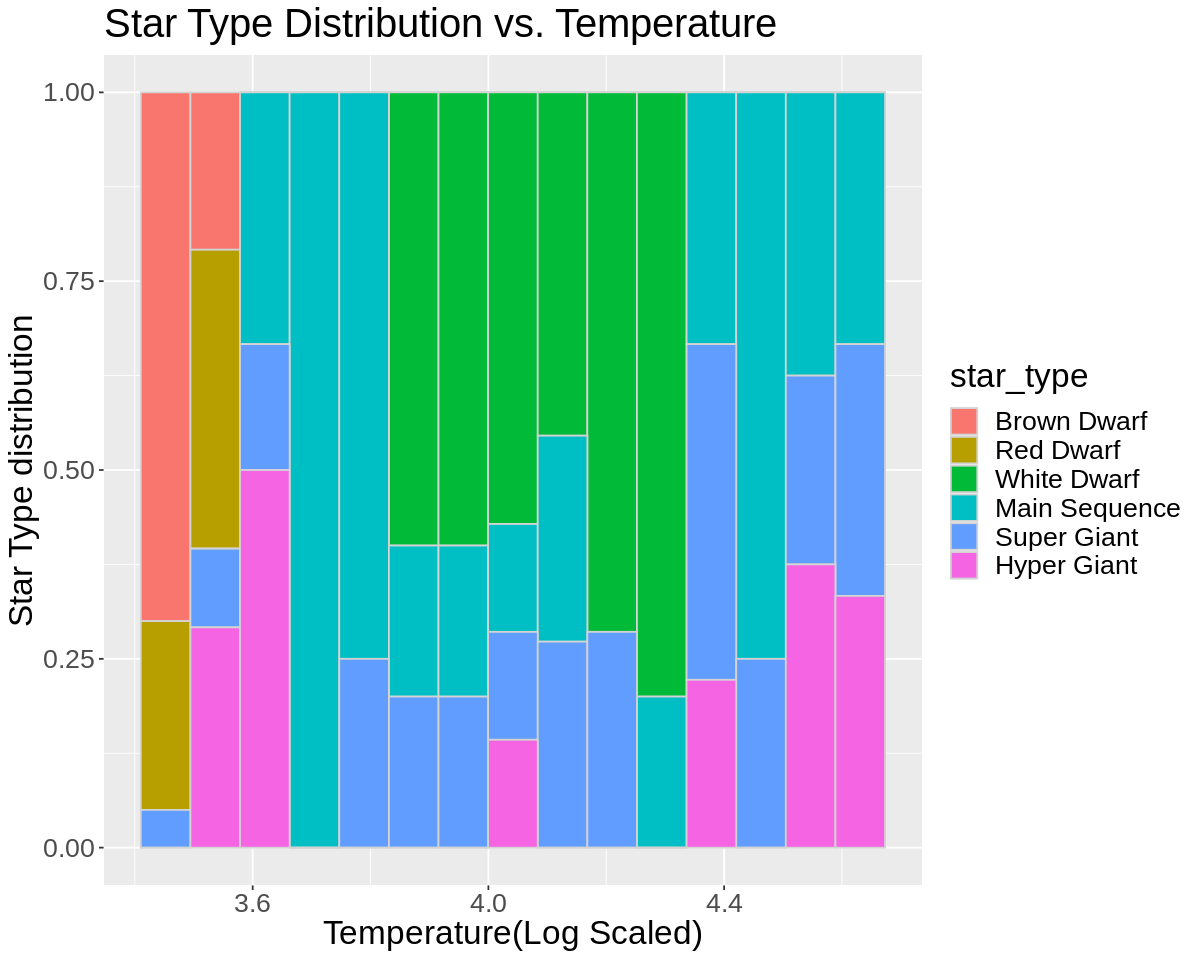

In [38]:
#Plot to see distribution of star type and temperature
star_temp_plot <- star_train %>%
    ggplot(aes(x = temperature, fill = star_type)) +
    geom_histogram(position = "fill", color = "lightgrey", bins = 15) +
    ggtitle("Star Type Distribution vs. Temperature") +
    labs(x = "Temperature(Log Scaled)", y = "Star Type distribution", color = "Star Type") +
    theme(text = element_text(size = 20))

star_temp_plot

**Figure 4**

After observing Figure 1, Figure 3, and Figure 4 it seems like the temperature might not be the best predictor because many different star types can have the same temperature so want to test out a model where we include all predictors with a arbitrary value of K and see how accurate out model is because judging from the figures, star types such as hyper giants and super giants might be misclassified. So lets create a model with k = 7 and using temperature, radius, and luminosity as predictors. We will apply cross validation to determine accuracy because we don't want to touch our test data yet until we build the best model.

In [39]:
#Star Vfold to apply cross-validation
star_vfold <- vfold_cv(star_train, v = 10, strata = star_type)

#K-nearest neighbor model specification: pre cross-validation
knn_spec_temp <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe_temp <- recipe(star_type ~ radius + luminosity + temperature, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit_temp <- workflow() %>%
    add_recipe(star_recipe_temp) %>%
    add_model(knn_spec_temp) %>%
    tune_grid(resamples = star_vfold, grid = tibble(neighbors = seq(1,20)))

# #Collect the summary of our cross-validation
star_summary_temp <- star_fit_temp %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

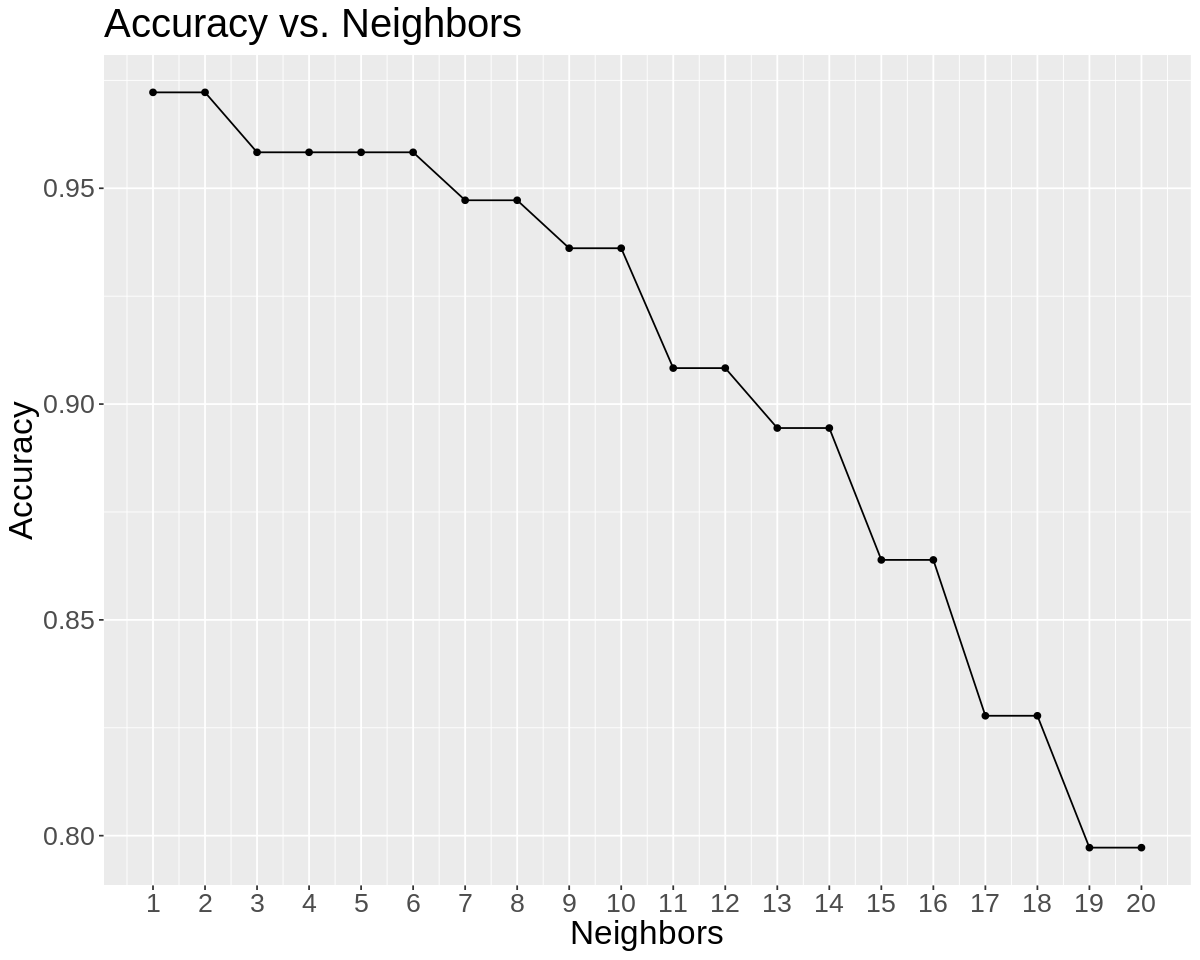

In [40]:
#Plot of accuracy vs. neighbors  
star_accuracy_plot <- star_summary_temp %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs. Neighbors") +
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:20)

star_accuracy_plot

**Figure 5**

In [41]:
#Best K value
k_min <- star_summary_temp %>%
    arrange(desc(mean)) %>% 
    slice(1) %>%
    select(neighbors) %>%
    pull()

k_min

[1] 1

In [42]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec_temp <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Put together everything into a workflow
star_fit_temp <- workflow() %>%
    add_recipe(star_recipe_temp) %>%
    add_model(knn_spec_temp) %>%
    fit_resamples(resamples = star_vfold)

# #Collect the summary of our cross-validation
star_summary_temp <- star_fit_temp %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_summary_temp

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.9722222,10,0.01171214


**Table 2**

Our accuracy is quite high with temperature included but we want to test our hypothesis that our model will be better off without including temperature

In [ ]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe <- recipe(star_type ~ radius + luminosity, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = star_vfold, grid = tibble(neighbors = seq(1,20)))

# #Collect the summary of our cross-validation
star_summary <- star_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_summary

In [ ]:
#Plot of accuracy vs. neighbors  
star_accuracy_plot <- star_summary %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs. Neighbors") +
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:20)

star_accuracy_plot

**Figure 5**

In [ ]:
#Best K value
k_min <- star_summary %>%
    arrange(desc(mean)) %>% 
    slice(1) %>%
    select(neighbors) %>%
    pull()

k_min

In [ ]:
#Retrained model with new k value 
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

star_best_accuracy <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit_resamples(resamples = star_vfold) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_best_accuracy

**Table 3**

In [ ]:
star_best_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(data = star_train) 

star_predictions <- star_best_fit %>%
    predict(star_test) %>%
    bind_cols(star_test)

In [ ]:
star_metrics <- star_predictions %>%
    metrics(truth = star_type, estimate = .pred_class)

star_metrics

**Table 4**

In [ ]:
star_conf_mat <- star_predictions %>%
    conf_mat(truth = star_type, estimate = .pred_class)

star_conf_mat

**Table 5**

In [ ]:
# create the grid of area/smoothness vals, and arrange in a data frame
lum_grid <- seq(min(star_data$luminosity), 
                max(star_data$luminosity), 
                length.out = 100)
rad_grid <- seq(min(star_data$radius), 
                max(star_data$radius), 
                length.out = 100)
asgrid <- tibble(expand.grid(luminosity = lum_grid, 
                                radius = rad_grid))

star_final_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(data = star_train)

knnPredGrid <- predict(star_final_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid point
wkflw_plot <-
  ggplot() +
  geom_point(data = star_data, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                          color = star_type), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                           color = Class), 
             alpha = 0.06, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Radius (Log Scaled)", 
       y = "Luminosity (Log Scaled)") +
  scale_color_manual(labels = c("White Dwarf", "Main Sequence", "Brown Dwarf", "Red Dwarf", "Hyper Giant", "Super Giant"), 
                     values = c("azure4", "chartreuse4", "brown", "brown1", "darkorchid2", "deeppink1")) +
theme(text = element_text(size = 20))

wkflw_plot

**Figure 6**

In [ ]:
star_accuracy <- star_best_fit %>%
    predict(star_test) %>%
    bind_cols(star_test) %>%
    mutate(prediction = ifelse(.pred_class == star_type, "correct", "incorrect")) %>%
    group_by(star_type, prediction) %>%
    summarize(n = n())

star_accuracy

**Table 6**

In [ ]:
star_accuracy_plot <- star_accuracy %>%
    ggplot(aes(x = star_type, y = n, fill = prediction)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "RdYlBu") +
    ggtitle("Predictions vs. Star Type") +
    labs(x = "Star Type", y = "Correct vs. Incorrect Proportion", color = "Predictions") +
    theme(text = element_text(size = 15))

star_accuracy_plot

**Figure 7**